<a href="https://colab.research.google.com/github/NodiraTillayeva/ERA5Analysis/blob/main/WindData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluating the renewable energy potential (wind and solar) in Uzbekistan

Download ERA5 Data from https://cds.climate.copernicus.eu/how-to-api

You can do it mannually on the website or utilize cds api which im gonna install below

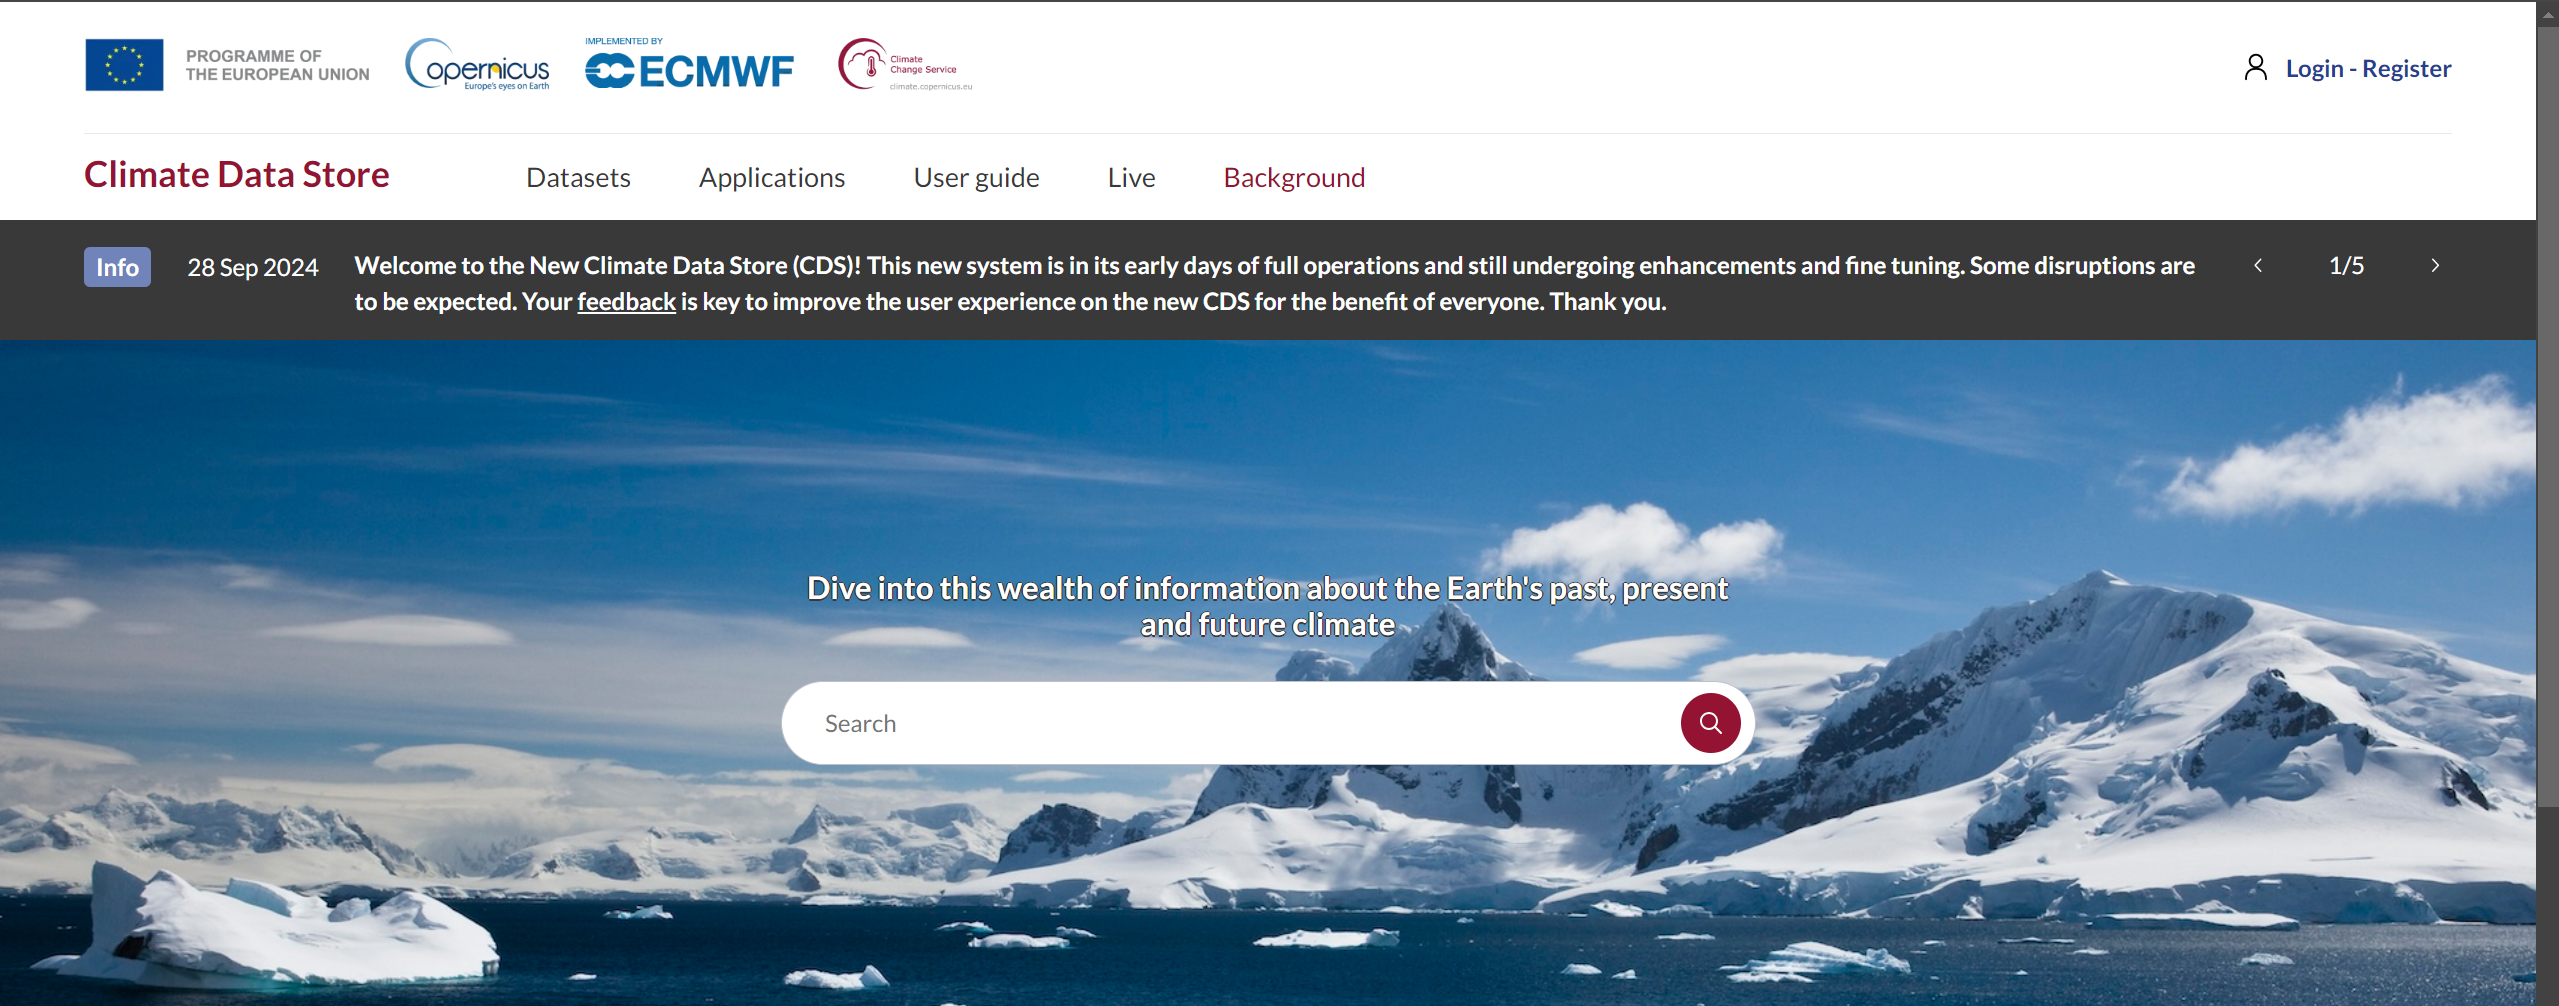

In [1]:
pip install cdsapi

  Preparing metadata (setup.py) ... done
  Created wheel for multiurl: filename=multiurl-0.3.1-py3-none-any.whl size=21131 sha256=5a2b45e90bf1166f783997ec39430a1095cf0837f94a3ff6e79b87883d8cbf81
  Stored in directory: /root/.cache/pip/wheels/9b/d9/5f/36a39fd10d15b5b2d362ad6dc8a1bd28a3b1e14e08357944bf
Successfully built multiurl


For this step you need to

Register for an API Key:


1.   Go to the Copernicus Climate Data Store (CDS) and log in or sign up for an account.
2.   After logging in, go to your API key page, where you will find the API key in the format:



> url: https://cds.climate.copernicus.eu/api/v2

> key: UID: API key



Create the .cdsapirc Configuration File:

On your local machine, navigate to your home directory and create the .cdsapirc file:


> nano ~/.cdsapirc

Add the following content to the file (replace <UID> and <API key> with your actual credentials)



In [6]:
# Replace <UID> and <API key> with your actual Copernicus credentials
api_key = """
  url:
  key:
"""

# Write to the .cdsapirc file
with open('/root/.cdsapirc', 'w') as file:
    file.write(api_key)

Now retrieving parameters

Keep in mind that we are downloading data on


*   10m_u_component_of_wind
*   10m_v_component_of_wind
*   surface_solar_radiation_downwards

for everyday 4 times a day in 2023

So the process of retrieval might take a lot




In [34]:
import cdsapi

c = cdsapi.Client()

# Request wind speed and solar radiation data
c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'variable': [
            '10m_u_component_of_wind', '10m_v_component_of_wind', 'surface_solar_radiation_downwards',
        ],
        'area': [45, 55, 37, 73],  # Coordinates for Uzbekistan (North, West, South, East)
        'year': '2023',
        'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'],
        'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31'],
        'time': ['00:00', '06:00', '12:00', '18:00'],
        'format': 'netcdf',
    },
    'uzbekistan_renewable_energy.nc')

2024-10-10 12:23:54,523 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
INFO:cads_api_client.legacy_api_client:[2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-10-10 12:23:54,526 WARNING [2024-09-26T00:00:00] Should you have not yet migrated from the old CDS system to the new CDS, please check our [informa

76bb3448e9a0106063587fca8836c75b.nc:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

'uzbekistan_renewable_energy.nc'

The data will be retrieved in **netCDF4** format data

NetCDF (network Common Data Form) is a file format for storing multidimensional scientific data (variables) such as temperature, humidity, pressure, wind speed, and direction. Each of these variables can be displayed through a dimension (such as time)

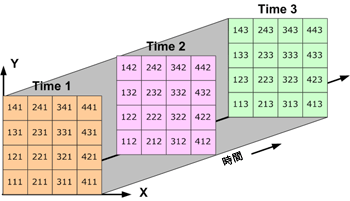

We will need the following libraries to analyze this type of data


In [8]:
pip install xarray netCDF4 numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.4 MB/s eta 0:00:00


## Load the NetCDF File (.*nc*)

In [9]:
import xarray as xr

# Load the data
data = xr.open_dataset('uzbekistan_renewable_energy.nc')

# Extract variables
u10 = data['u10']  # Eastward wind component
v10 = data['v10']  # Northward wind component
ssrd = data['ssrd']  # Surface solar radiation downwards

# Calculate wind speed
wind_speed = (u10**2 + v10**2)**0.5

## Analyze Dataset

In [11]:
# Calculate the mean wind speed over the 'valid_time' dimension
mean_wind_speed = wind_speed.mean(dim='valid_time')

# Find areas with wind speed greater than a threshold (e.g., 5 m/s)
optimal_wind_areas = mean_wind_speed.where(mean_wind_speed > 5)

In [12]:
# Convert solar radiation from J/m² to kWh/m² (1 J = 2.77778e-7 kWh)
ssrd_kwh = ssrd * 2.77778e-7

# Sum solar radiation over the 'valid_time' dimension
total_solar_radiation = ssrd_kwh.sum(dim='valid_time')

# Find areas with high solar radiation potential
optimal_solar_areas = total_solar_radiation.where(total_solar_radiation > 1500)


## Vizualize

In [35]:
import matplotlib.pyplot as plt

# Save the matplotlib figure as an image
plt.figure(figsize=(10, 6))
mean_wind_speed.plot(cmap='viridis')
plt.title('Mean Wind Speed in Uzbekistan (m/s)')
plt.savefig('mean_wind_speed.png', bbox_inches='tight', dpi=150)  # Save it as a PNG file
plt.close()

In [53]:
import folium
from folium.raster_layers import ImageOverlay
import matplotlib.pyplot as plt

# Save the matplotlib figure as an image
plt.figure(figsize=(10, 6))
mean_wind_speed.plot(cmap='viridis')
plt.title('Mean Wind Speed in Uzbekistan (m/s)')
plt.savefig('mean_wind_speed.png', bbox_inches='tight', dpi=150)  # Save it as a PNG file
plt.close()

# Define the bounds (latitude and longitude of the region covering Uzbekistan)
bounds = [[37.0, 55.0], [45.0, 73.0]]  # [South-West corner, North-East corner]

# Create a folium map centered on Uzbekistan
map_center = [41.5, 64.0]  # Center of Uzbekistan
m1 = folium.Map(location=map_center, zoom_start=6)

# Add the image overlay on the map
image_overlay = ImageOverlay(image='mean_wind_speed.png', bounds=bounds, opacity=0.6)
image_overlay.add_to(m1)

# Save or display the map
m1.save('uzbekistan_wind_speed_map.html')

# If you're in a Jupyter notebook, you can display it directly
# m



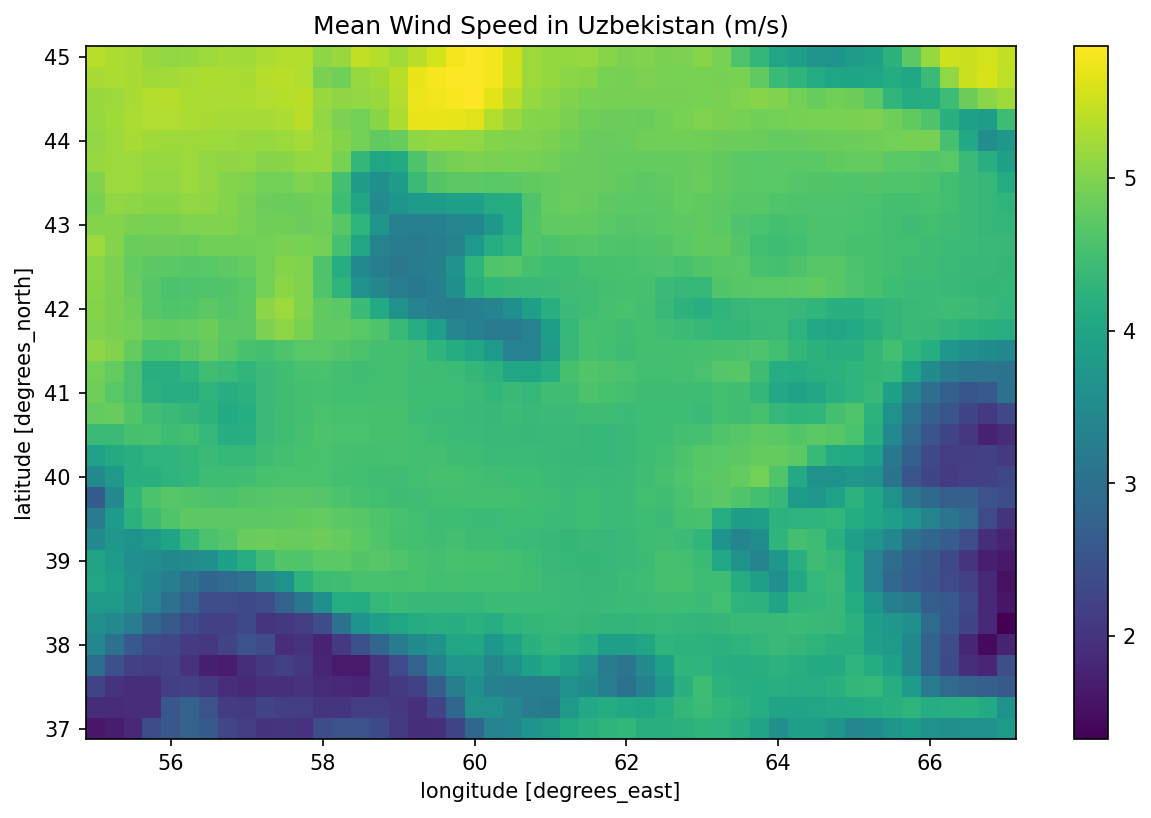

In [54]:
m1

## Select places that are suitable for wind stations

In [55]:
import folium
import geopandas as gpd
import numpy as np
from folium.plugins import HeatMap
from shapely.geometry import Polygon

# Load your dataset
data = xr.open_dataset('uzbekistan_renewable_energy.nc')

# Extract wind speed and coordinates
u10 = data['u10']  # Eastward wind component
v10 = data['v10']  # Northward wind component
wind_speed = (u10**2 + v10**2)**0.5

# Get the mean wind speed across time
mean_wind_speed = wind_speed.mean(dim='valid_time')

# Get the latitude and longitude arrays
lat = data['latitude'].values
lon = data['longitude'].values
mean_wind_speed_values = mean_wind_speed.values

# Set a wind speed threshold for suitable locations (e.g., 5 m/s)
threshold = 4.8

# Create a list to store polygons for suitable areas
polygons = []

for i in range(len(lat) - 1):
    for j in range(len(lon) - 1):
        # Check if the wind speed is above the threshold
        if mean_wind_speed_values[i, j] >= threshold:
            # Create a polygon for this grid cell
            polygon = Polygon([
                (lon[j], lat[i]),      # Bottom-left
                (lon[j+1], lat[i]),    # Bottom-right
                (lon[j+1], lat[i+1]),  # Top-right
                (lon[j], lat[i+1]),    # Top-left
                (lon[j], lat[i])       # Close the polygon
            ])
            polygons.append(polygon)

# Create a GeoDataFrame to store the polygons
gdf = gpd.GeoDataFrame(geometry=polygons)

# Set the coordinate reference system (CRS) to WGS84 (EPSG:4326)
gdf.set_crs(epsg=4326, inplace=True)

# Create a folium map centered around Uzbekistan
map_center = [41.5, 64.0]  # Coordinates of Uzbekistan's approximate center
m = folium.Map(location=map_center, zoom_start=6)

# Add the polygons to the map
for _, row in gdf.iterrows():
    # Convert the polygon to GeoJSON and add it to the folium map
    folium.GeoJson(row['geometry'], style_function=lambda x: {'fillColor': 'blue', 'color': 'blue', 'weight': 1}).add_to(m)

# Save the map to an HTML file or display it
m.save('uzbekistan_wind_station_map.html')

# If you are in a Jupyter notebook, you can display the map directly:
# m


In [56]:
m